In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [43]:
import numpy as np
import data_loader
import config
import pmcx
from matplotlib import pyplot as plt
from mcs_function import SimulationAttenuation

In [44]:
pmcx.gpuinfo()

[{'name': 'Quadro RTX 8000',
  'id': 1,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 2,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 3,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 4,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedme

=============================   GPU Information  ================================
Device 1 of 8:		Quadro RTX 8000
Compute Capability:	7.5
Global Memory:		50953846784 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.77 GHz
Number of SMs:		72
Number of Cores:	4608
Auto-thread:		147456
Auto-block:		64
=============================   GPU Information  ================================
Device 2 of 8:		Quadro RTX 8000
Compute Capability:	7.5
Global Memory:		50953846784 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.77 GHz
Number of SMs:		72
Number of Cores:	4608
Auto-thread:		147456
Auto-block:		64
=============================   GPU Information  ================================
Device 3 of 8:		Quadro RTX 8000
Compute Capability:	7.5
Global Memory:		50953846784 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.77 GHz
Number of SMs:		72
Number of Cores:	4608
Auto-thread:		147456
Auto-blo

In [45]:
config.gpuid

4

In [46]:
config.mcs_func_path

PosixPath('/home/leon_ivan/data/mcs_function_data/function_data.npz')

In [11]:
mu_s_bounds = np.concatenate((
    data_loader.DataLoader.mu_s_red_func_gray_matter(np.array([450, 1000])) / (1-0.85),
    data_loader.DataLoader.mu_s_red_func_blood_vessel(np.array([450, 1000])) / (1-0.935)
))
print(mu_s_bounds)

[376.62903055  31.96592289 362.83507885 214.20496206]


In [12]:
mu_s_vals = np.linspace(10, 500, 30)
print(mu_s_vals)

[ 10.          26.89655172  43.79310345  60.68965517  77.5862069
  94.48275862 111.37931034 128.27586207 145.17241379 162.06896552
 178.96551724 195.86206897 212.75862069 229.65517241 246.55172414
 263.44827586 280.34482759 297.24137931 314.13793103 331.03448276
 347.93103448 364.82758621 381.72413793 398.62068966 415.51724138
 432.4137931  449.31034483 466.20689655 483.10344828 500.        ]


In [13]:
g_combined = 0.8675
refractive_index_combined = 1.38

In [47]:
# very deep tissue necessary, since no absorption allows photons to go deep into tissue
# for faster and statiscally better results, increasy voxel size
vol = np.ones((50, 50, 1000))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 10

cfg = {
    "nphoton": 5e5, # keep nphotons relatively low, to limit memory of stored data
    "maxdetphoton": 5e5,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [48]:
function_data = []
function_data.append(cfg["nphoton"])
function_data.append(mu_s_vals)

In [55]:
for i, mu_s in enumerate(mu_s_vals):
    cfg["prop"][1, 1] = mu_s / 10 # mu_s_vals are stored in cm^-1
    cfg["prop"][1, 0] = 0
    cfg["prop"][1, 2] = g_combined
    cfg["prop"][1, 3] = refractive_index_combined
    print(f"Iteration {i}/{len(mu_s_vals)}")
    res = pmcx.mcxlab(cfg)
    cur_photon_data = np.row_stack(
        (
            res["detp"]["ppath"][:, 0] * cfg["unitinmm"] / 10, # store pathlength in cm. pathlengths are stored in "unitinmm"
            res["detp"]["nscat"][:, 0]
        )
    )
    print(f"Mean path length: {pmcx.utils.meanpath(res['detp'])}")
    function_data.append(cur_photon_data)

np.savez(config.mcs_func_path, *function_data)

Iteration 0/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
Mean path length: [304.74260794]
Iteration 1/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [197.25898885]
Iteration 2/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [157.55136649]
Iteration 3/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	136 ms
retrieving fields ... 	detected 460790 photons, total: 460790	transfer complete:	141 ms
normalizing raw data ...	source

Mean path length: [135.7970965]
Iteration 4/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	171 ms
retrieving fields ... 	detected 466660 photons, total: 466660	transfer complete:	176 ms
normalizing raw data ...	source

Mean path length: [120.64398077]
Iteration 5/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	200 ms
retrieving fields ... 	detected 470345 photons, total: 470345	transfer complete:	205 ms
normalizing raw data ...	source

Mean path length: [109.70668531]
Iteration 6/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	230 ms
retrieving fields ... 	detected 473093 photons, total: 473093	transfer complete:	238 ms
normalizing raw data ...	source

Mean path length: [101.32572183]
Iteration 7/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	257 ms
retrieving fields ... 	detected 475168 photons, total: 475168	transfer complete:	262 ms
normalizing raw data ...	source

Mean path length: [94.76259042]
Iteration 8/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [89.58671746]
Iteration 9/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	309 ms
retrieving fields ... 	detected 478269 photons, total: 478269	transfer complete:	315 ms
normalizing raw data ...	source

Mean path length: [85.15391571]
Iteration 10/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [81.12851816]
Iteration 11/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	351 ms
retrieving fields ... 	detected 480380 photons, total: 480380	transfer complete:	358 ms
normalizing raw data ...	source

Mean path length: [77.53169796]
Iteration 12/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [74.35989247]
Iteration 13/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [71.7021067]
Iteration 14/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [69.34399288]
Iteration 15/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [67.1336726]
Iteration 16/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [65.27490039]
Iteration 17/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [63.41713528]
Iteration 18/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	518 ms
retrieving fields ... 	detected 484636 photons, total: 484636	transfer complete:	525 ms
normalizing raw data ...	source

Mean path length: [61.85380377]
Iteration 19/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	555 ms
retrieving fields ... 	detected 485022 photons, total: 485022	transfer complete:	566 ms
normalizing raw data ...	source

Mean path length: [60.15953046]
Iteration 20/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [58.97856688]
Iteration 21/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [57.63728163]
Iteration 22/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	609 ms
retrieving fields ... 	detected 486153 photons, total: 486153	transfer complete:	618 ms
normalizing raw data ...	source

Mean path length: [56.36218516]
Iteration 23/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [55.30586935]
Iteration 24/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [54.23426079]
Iteration 25/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [53.20631191]
Iteration 26/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 2 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	726 ms
retrieving fields ... 	detected 487329 photons, total: 487329	transfer complete:	731 ms
normalizing raw data ...	source

Mean path length: [52.16891835]
Iteration 27/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
Mean path length: [51.05802661]
Iteration 28/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [50.20218436]
Iteration 29/30
nphoton: 500000
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 500000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=3 extra=57632 np=500000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	790 ms
retrieving fields ... 	detected 487973 photons, total: 487973	transfer complete:	798 ms
normalizing raw data ...	source

Mean path length: [49.55874959]


Load Data and plot for some mu_a values

In [50]:
function_data_loaded = np.load(config.mcs_func_path)
nphoton = function_data_loaded["arr_0"]
mu_s_vals = function_data_loaded["arr_1"]

In [51]:
mu_a_bounds = np.concatenate((
    data_loader.DataLoader.mu_a_func_gray_matter(np.array([450, 999])),
    data_loader.DataLoader.mu_a_func_blood_vessel(np.array([450, 999])) 
))
print(mu_a_bounds)
mu_a_samples = np.linspace(np.min(mu_a_bounds) * 0.75, np.max(mu_a_bounds) * 1.25, 5)

[ 12.54812692   0.51441594 334.53358048   5.45180551]


Text(0, 0.5, 'Attenuation')

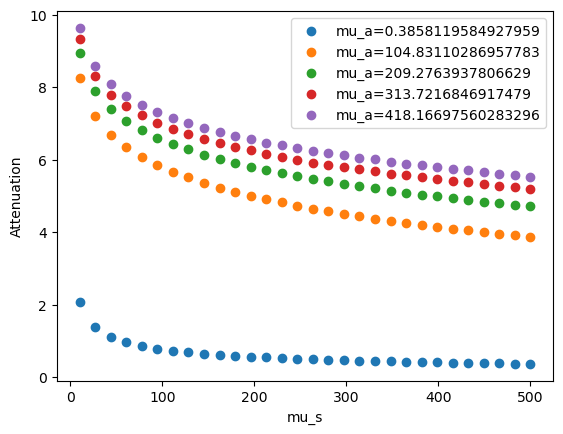

In [52]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 2}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)

    plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")


Same plot but with randomly sampled, then interpolated values for mu_s...

In [53]:
mcs_obj = SimulationAttenuation(config.mcs_func_path)

Loaded data with 500000.0 photons and 30 values for mu_s.


Text(0, 0.5, 'Attenuation')

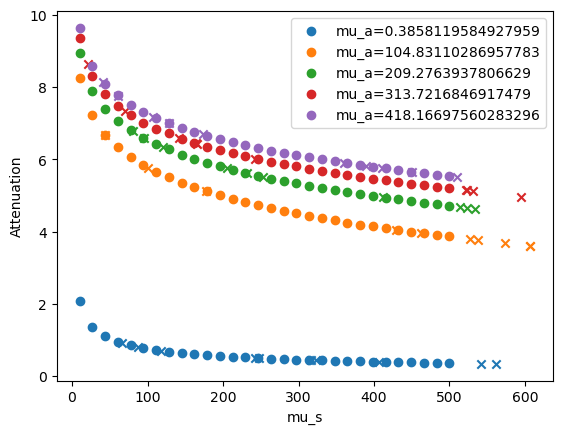

In [54]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 2}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)
    
    p = plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")

    mu_s_vals_sampled = np.random.rand(10) * (mu_s_vals[-1] - mu_s_vals[0]) * 1.25 + mu_s_vals[0]
    attenuation_interpolated =  mcs_obj.A(mu_a, mu_s_vals_sampled)
    plt.scatter(mu_s_vals_sampled, attenuation_interpolated, marker="x", color=p.get_facecolor()[0])

    
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")

Sampe graph, but compare with attenuation based on perturbation Monte Carlo method, with mean mu_a, mu_s values as baseline.
This barely works because of overflows.

In [ ]:
mu_a_baseline = mu_a_samples[len(mu_a_samples)//2]
mu_s_baseline = mu_s_vals[-1]
photon_ppath_baseline, photon_nscat_baseline = function_data_loaded[f"arr_{2 + len(mu_s_vals) - 1}"][:, :]
weights_baseline = np.exp(-mu_a_baseline * photon_ppath_baseline)

In [ ]:
np.min(photon_nscat_baseline)

In [ ]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    attenuation_per_mu_a_perturbed = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 2}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)

    p = plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")

    mu_s_vals_sampled = np.random.rand(10) * (mu_s_vals[-1] - mu_s_vals[0]) + mu_s_vals[0]
    photon_weights_perturbed = weights_baseline * np.power((mu_s_vals_sampled/mu_s_baseline)[:, None], photon_nscat_baseline[None, :])
    photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
    photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])
    attenuation_perturbed = -np.log(np.sum(photon_weights_perturbed, axis=-1) / nphoton)

    plt.scatter(mu_s_vals_sampled, attenuation_perturbed, marker="x", color=p.get_facecolor()[0])

    
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")

In [ ]:
plt.plot(mu_s_vals, dref2)

mu_s_ref = mu_s_vals[len(mu_s_vals) // 2]
k = -mu_s_vals / mu_s_ref
dref_ref = dref2[len(mu_s_vals) // 2]
plt.plot(mu_s_vals, k**2 * dref_ref)